# Librerías

In [2]:
#Librerías para subir los datos
from google.colab import files
import io

import pandas as pd

import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import numpy as np


%matplotlib inline 

In [3]:
#Importamos modulos
from warnings import filterwarnings
filterwarnings('ignore')
import pandas as pd
import numpy as np
import io
import requests
import seaborn as sns
import timeit
import math
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
from sklearn import neighbors

#from google.colab import files
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

#Parámetros para visualización
sns.set(style='whitegrid', color_codes=True) #whitegrid #darkgrid

# Funciones

In [4]:
def upload_files (sep=','):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), sep=sep)
    # df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col='Unnamed: 0') # index sin nombre
    return df

In [5]:
def split_dataset_train_test(df_train, df_test):
  X_train, y_train=df_train.drop(['num_casos','fecha'], axis=1), df_train['num_casos']
  X_test, y_test = df_test.drop(['num_casos','fecha'], axis=1), df_test['num_casos']
  return X_train, y_train, X_test, y_test

In [6]:
def evaluar_modelo(df_test, df_train, models):
  X_train, y_train, X_test, y_test = split_dataset_train_test(df_train=df_train,
                                                              df_test=df_test)

  models_error=dict()
  models_fit=dict()
  models_predict=dict()
  for key,model in models.items():
      model.fit(X=X_train,y=y_train)
      # predicciones
      predict=model.predict(X_test)
      # error mae
      mae= metrics.mean_absolute_error(y_test, predict)
      # error cuadratico medio
      rmse= np.sqrt (metrics.mean_squared_error(y_test, predict)) 
      #  error cuadratico r2
      score= metrics.r2_score(y_test,predict) 
      # dict con errores del modelo
      models_error[key]={'MAE':round (mae,3), 'RMSE':round (rmse,3), 'SCORE':round(score,3)  }
      # valores de prediccion
      models_predict[key]=predict
      # sacamos el dict de modelos
      models_fit[key]=model
  return (models_fit, models_predict,models_error) 

In [7]:
def show_error_for_ca(y_pred_rfr, y_pred_xgbr, y_pred_gbr, y_pred_abr, dataset, test_ini, test_fin, df_ccaa, criterion='rmse'):
  # y_pred_rfr, y_pred_xgbr, y_pred_gbr, y_pred_abr -- valores de la prediccion del modelo 

    # df de test
    df = dataset[dataset['fecha'].isin(pd.date_range (test_ini,test_fin))]

    df['predict_XGBoost']=y_pred_xgbr
    df['predict_AdaBoost']=y_pred_abr
    df['predict_RandomForest']=y_pred_rfr
    df['predict_GradientBoosting']=y_pred_gbr

    best_model={}
    best_error=0
    for ca in df['cod_ine'].unique():
        df_ca = df[df['cod_ine']==ca]
        if criterion == 'mae':
            #XGBoost
            mae= metrics.mean_absolute_error(df_ca['num_casos'], df_ca['predict_XGBoost'])
            rmse= np.sqrt (metrics.mean_squared_error(df_ca['num_casos'], df_ca['predict_XGBoost']))
            score= metrics.r2_score(df_ca['num_casos'],df_ca['predict_XGBoost'])
            best_error=mae
            best_model[ca]={'nombre_ccaa':df_ccaa['nombre_ccaa'][ca], 'cod_ine':ca, 'Modelo':'XGBoost', 'MAE':round (mae,3), 
                            'RMSE':round (rmse,3), 'SCORE': round (score, 3) }
            #AdaBoost
            mae= metrics.mean_absolute_error(df_ca['num_casos'], df_ca['predict_AdaBoost'])
            rmse= np.sqrt (metrics.mean_squared_error(df_ca['num_casos'], df_ca['predict_AdaBoost']))
            score= metrics.r2_score(df_ca['num_casos'],df_ca['predict_AdaBoost'])
            if mae<best_error:
                best_error=mae
                best_model[ca]={'nombre_ccaa':df_ccaa['nombre_ccaa'][ca], 'ccaa_iso':ca, 'Modelo':'AdaBoost', 'MAE':round (mae,3),
                                'RMSE':round (rmse,3), 'SCORE': round (score, 3) }
            #RandomForest
            mae= metrics.mean_absolute_error(df_ca['num_casos'], df_ca['predict_RandomForest'])
            rmse= np.sqrt (metrics.mean_squared_error(df_ca['num_casos'], df_ca['predict_RandomForest']))
            score= metrics.r2_score(df_ca['num_casos'],df_ca['predict_RandomForest'])
            if mae<best_error:
                best_error=mae
                best_model[ca]={'nombre_ccaa':df_ccaa['nombre_ccaa'][ca], 'cod_ine':ca, 'Modelo':'RandomForest', 'MAE':round (mae,3), 
                                'RMSE':round (rmse,3), 'SCORE': round (score, 3) }
            #GradientBoosting
            mae= metrics.mean_absolute_error(df_ca['num_casos'], df_ca['predict_GradientBoosting'])
            rmse= np.sqrt (metrics.mean_squared_error(df_ca['num_casos'], df_ca['predict_GradientBoosting']))
            score= metrics.r2_score(df_ca['num_casos'],df_ca['predict_GradientBoosting'])
            if mae<best_error:
                best_error=mae
                best_model[ca]={'nombre_ccaa':df_ccaa['nombre_ccaa'][ca], 'cod_ine':ca, 'Modelo':'GradientBoosting', 'MAE':round (mae,3), 
                                'RMSE':round (rmse,3), 'SCORE': round (score, 3) }
        else:
            #XGBoost
            mae= metrics.mean_absolute_error(df_ca['num_casos'], df_ca['predict_XGBoost'])
            rmse= np.sqrt (metrics.mean_squared_error(df_ca['num_casos'], df_ca['predict_XGBoost']))
            score= metrics.r2_score(df_ca['num_casos'], df_ca['predict_XGBoost']) 
            #print ('XGBoost: MAE:', mae, 'RMSE:', rmse)
            best_error=rmse
            best_model[ca]={'nombre_ccaa':df_ccaa['nombre_ccaa'][ca], 'cod_ine':ca, 'Modelo':'XGBoost', 'MAE':round (mae,3), 
                            'RMSE':round (rmse,3), 'SCORE': round (score, 3) }
            #AdaBoost
            mae= metrics.mean_absolute_error(df_ca['num_casos'], df_ca['predict_AdaBoost'])
            rmse= np.sqrt (metrics.mean_squared_error(df_ca['num_casos'], df_ca['predict_AdaBoost']))
            score= metrics.r2_score(df_ca['num_casos'], df_ca['predict_AdaBoost']) 
            #print ('AdaBoost: MAE:', mae, 'RMSE:', rmse)
            if rmse<best_error:
                best_error=rmse
                best_model[ca]={'nombre_ccaa':df_ccaa['nombre_ccaa'][ca], 'cod_ine':ca, 'Modelo':'AdaBoost', 'MAE':round (mae,3), 
                                'RMSE':round (rmse,3), 'SCORE': round (score, 3) }
            #RandomForest
            mae= metrics.mean_absolute_error(df_ca['num_casos'], df_ca['predict_RandomForest'])
            rmse= np.sqrt (metrics.mean_squared_error(df_ca['num_casos'], df_ca['predict_RandomForest']))
            score= metrics.r2_score(df_ca['num_casos'], df_ca['predict_RandomForest'])
            #print ('RandomForest: MAE:', mae, 'RMSE:', rmse)
            if rmse<best_error:
                best_error=rmse
                best_model[ca]={'nombre_ccaa':df_ccaa['nombre_ccaa'][ca], 'cod_ine':ca, 'Modelo':'RandomForest', 'MAE':round (mae,3), 
                                'RMSE':round (rmse,3),  'SCORE': round (score, 3) }
            #GradientBoosting
            mae= metrics.mean_absolute_error(df_ca['num_casos'], df_ca['predict_GradientBoosting'])
            rmse= np.sqrt (metrics.mean_squared_error(df_ca['num_casos'], df_ca['predict_GradientBoosting'])) 
            score= metrics.r2_score(df_ca['num_casos'], df_ca['predict_GradientBoosting'])
            #print ('GradientBoosting: MAE:', mae, 'RMSE:', rmse)
            if rmse<best_error:
                best_error=rmse
                best_model[ca]={'nombre_ccaa':df_ccaa['nombre_ccaa'][ca], 'cod_ine':ca, 'Modelo':'GradientBoosting', 'MAE':round (mae,3), 
                                'RMSE':round (rmse,3), 'SCORE': round (score, 3)  }

    best_model=pd.DataFrame (best_model).T
    display(best_model)
    return (best_model)

# Minería del dato

In [8]:
# carga de nuestros datos
df = upload_files()

Saving df_interpolated_final.csv to df_interpolated_final.csv
User uploaded file "df_interpolated_final.csv" with length 2162238 bytes


In [8]:
df.columns

Index(['ccaa_iso', 'fecha', 'num_casos', 'lug_ocio', 'lug_mercado',
       'lug_parque', 'lug_estacion', 'lug_trabajo', 'lug_residencial',
       'dosis_administradas', 'porcentaje_dosis_administradas',
       'personas_una_dosis', 'personas_pauta_completa',
       'porcentaje_pauta_completa', 'Fallecidos', 'Hospitalizados', 'UCI',
       'CCAA', 'cod_ine', 'Población', 'dia_sem', 'dia_year', 'dia_mes',
       'is_weekend', 'incidencia'],
      dtype='object')

In [9]:
df_ccaa = upload_files(sep=";")

Saving codigos_ccaa.csv to codigos_ccaa.csv
User uploaded file "codigos_ccaa.csv" with length 1011 bytes


In [ ]:
df_ccaa

,cod_ISO-3166,ccaa_iso,Nombre_CCAA_covid,Nombre_CCAA_mov,cod_ine,Nombre_CCAA_vac
0,ES-AN,AN,Andalucía,Andalusia,1,Andalucía
1,ES-AR,AR,Aragón,Aragon,2,Aragón
2,ES-AS,AS,Principado de Asturias,Asturias,3,Asturias
3,ES-CN,CN,Canarias,Canary Islands,5,Canarias
4,ES-CB,CB,Cantabria,Cantabria,6,Cantabria
5,ES-CM,CM,Castilla-La Mancha,Castile-La Mancha,8,Castilla La Mancha
6,ES-CL,CL,Castilla-León,Castile and León,7,Castilla y Leon
7,ES-CT,CT,Cataluña,Catalonia,9,Cataluña
8,ES-EX,EX,Extremadura,Extremadura,11,Extremadura
9,ES-GA,GA,Galicia,Galicia,12,Galicia


In [10]:
df_ccaa.drop(columns=['Nombre_CCAA_mov', 'Nombre_CCAA_vac', 'ccaa_iso'], inplace=True)
df_ccaa.rename(columns={"Nombre_CCAA_covid": "nombre_ccaa", "cod_ISO-3166": "cod_iso_ccaa"}, inplace=True)
df_ccaa.set_index('cod_ine', inplace=True)
df_ccaa

,cod_iso_ccaa,nombre_ccaa
cod_ine,,
1,ES-AN,Andalucía
2,ES-AR,Aragón
3,ES-AS,Principado de Asturias
5,ES-CN,Canarias
6,ES-CB,Cantabria
8,ES-CM,Castilla-La Mancha
7,ES-CL,Castilla-León
9,ES-CT,Cataluña
11,ES-EX,Extremadura


Dividimos el df entre train y test. Como los datos 

In [11]:
min_fecha=df.fecha.min()
max_fecha=df.fecha.max()
print (min_fecha, ':', max_fecha)

2020-01-31 : 2022-03-15


In [12]:
df['fecha'] = pd.to_datetime(df['fecha'],format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14725 entries, 0 to 14724
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ccaa_iso                        14725 non-null  object        
 1   fecha                           14725 non-null  datetime64[ns]
 2   num_casos                       14725 non-null  int64         
 3   lug_ocio                        14725 non-null  float64       
 4   lug_mercado                     14725 non-null  float64       
 5   lug_parque                      14725 non-null  float64       
 6   lug_estacion                    14725 non-null  float64       
 7   lug_trabajo                     14725 non-null  float64       
 8   lug_residencial                 14725 non-null  float64       
 9   dosis_administradas             14725 non-null  float64       
 10  porcentaje_dosis_administradas  14725 non-null  float64       
 11  pe

In [13]:
df.shape 

(14725, 25)

In [13]:
train_ini = min_fecha
train_fin = '2021-08-31'
test_ini = '2021-09-01'
test_fin = max_fecha

In [15]:
df.columns

Index(['ccaa_iso', 'fecha', 'num_casos', 'lug_ocio', 'lug_mercado',
       'lug_parque', 'lug_estacion', 'lug_trabajo', 'lug_residencial',
       'dosis_administradas', 'porcentaje_dosis_administradas',
       'personas_una_dosis', 'personas_pauta_completa',
       'porcentaje_pauta_completa', 'Fallecidos', 'Hospitalizados', 'UCI',
       'CCAA', 'cod_ine', 'Población', 'dia_sem', 'dia_year', 'dia_mes',
       'is_weekend', 'incidencia'],
      dtype='object')

In [14]:
numeric_cols = ['fecha', 'num_casos', 'lug_ocio', 'lug_mercado',
       'lug_parque', 'lug_estacion', 'lug_trabajo', 'lug_residencial',
       'dosis_administradas', 'porcentaje_dosis_administradas',
       'personas_una_dosis', 'personas_pauta_completa',
       'porcentaje_pauta_completa', 'cod_ine', 'dia_sem', 'dia_year', 
       'dia_mes', 'is_weekend', 'Población','incidencia']

In [15]:
df_numeric = df[numeric_cols]
df_numeric

,fecha,num_casos,lug_ocio,lug_mercado,lug_parque,lug_estacion,lug_trabajo,lug_residencial,dosis_administradas,porcentaje_dosis_administradas,personas_una_dosis,personas_pauta_completa,porcentaje_pauta_completa,cod_ine,dia_sem,dia_year,dia_mes,is_weekend,Población,incidencia
0,2020-01-31,0,5.0,-1.0,33.0,15.000000,0.0,-2.000000,0.0,0.00,0.0,0.0,0.00,1,4,31,31,0,8464411,0.000000
1,2020-01-31,0,3.0,7.0,42.0,10.000000,1.0,-3.000000,0.0,0.00,0.0,0.0,0.00,2,4,31,31,0,1329391,0.000000
2,2020-01-31,0,0.0,-1.0,20.0,8.000000,0.0,-1.000000,0.0,0.00,0.0,0.0,0.00,3,4,31,31,0,1018784,0.000000
3,2020-01-31,0,6.0,4.0,53.0,4.000000,-1.0,-2.000000,0.0,0.00,0.0,0.0,0.00,6,4,31,31,0,582905,0.000000
4,2020-01-31,0,-3.0,-6.0,3.0,-39.602941,-1.0,10.333333,0.0,0.00,0.0,0.0,0.00,18,4,31,31,0,84202,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14720,2022-03-15,11,-23.0,-11.0,-45.0,-22.000000,-14.0,5.000000,136751.0,162.25,65177.0,60611.0,71.91,19,1,74,15,0,86261,0.000128
14721,2022-03-15,269,-18.0,10.0,11.0,-14.000000,-2.0,2.000000,1291695.0,196.54,566266.0,547019.0,83.23,15,1,74,15,0,661537,0.000407
14722,2022-03-15,0,-23.0,5.0,7.0,-14.000000,-11.0,3.000000,4343580.0,198.38,1941477.0,1867147.0,85.28,16,1,74,15,0,2213993,0.000000
14723,2022-03-15,0,-21.0,10.0,-16.0,-13.000000,-3.0,2.000000,627460.0,198.48,282938.0,267241.0,84.53,17,1,74,15,0,319796,0.000000


In [16]:
df_train=df_numeric[df_numeric['fecha'].isin (pd.date_range (train_ini,train_fin))]
df_test=df_numeric[df_numeric['fecha'].isin (pd.date_range (test_ini,test_fin))]

In [17]:
df_test.shape

(3724, 20)

In [18]:
df_train.shape

(11001, 20)

Calculamos el error cuadratico

In [19]:
# definimos los modelos de árbol de decisiones
models=dict()
models['RF']= RandomForestRegressor(random_state=0, criterion='mae')
models['XGB']= XGBRegressor(eval_metric='mae',objective='reg:squarederror',random_state=0)
models['GB']= GradientBoostingRegressor(random_state=0,criterion='mae')
models['AB']= AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae'), random_state=0)

In [20]:
models_fit, models_predict, models_error = evaluar_modelo(df_test, df_train, models)
df_models_error = pd.DataFrame(models_error).T
df_models_error

,MAE,RMSE,SCORE
RF,658.108,2552.775,0.573
XGB,593.488,2387.120,0.626
GB,523.266,2269.401,0.662
AB,671.325,2573.568,0.566


# Iteración I: 

Añadimos los datos de casos al dia D con los valores de D-n con n [1,7]

In [ ]:
df

,ccaa_iso,fecha,num_casos,lug_ocio,lug_mercado,lug_parque,lug_estacion,lug_trabajo,lug_residencial,dosis_administradas,...,porcentaje_pauta_completa,Fallecidos,Hospitalizados,UCI,CCAA,cod_ine,dia_sem,dia_year,dia_mes,is_weekend
0,ES-AN,2020-01-31,0,5.0,-1.0,33.0,15.0,0.0,-2.0,0.0,...,0.00,0,0,0,Andalucía,1,4,31,31,0
1,ES-AR,2020-01-31,0,3.0,7.0,42.0,10.0,1.0,-3.0,0.0,...,0.00,0,0,0,Aragón,2,4,31,31,0
2,ES-AS,2020-01-31,0,0.0,-1.0,20.0,8.0,0.0,-1.0,0.0,...,0.00,0,0,0,Principado de Asturias,3,4,31,31,0
3,ES-CB,2020-01-31,0,6.0,4.0,53.0,4.0,-1.0,-2.0,0.0,...,0.00,0,0,0,Cantabria,6,4,31,31,0
4,ES-CE,2020-01-31,0,-3.0,-6.0,3.0,0.0,-1.0,0.0,0.0,...,0.00,0,0,0,Ceuta,18,4,31,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14720,ES-ML,2022-03-15,11,-23.0,-11.0,-45.0,4.0,-14.0,5.0,136751.0,...,71.91,0,1,0,Melilla,19,1,74,15,0
14721,ES-NC,2022-03-15,269,-18.0,10.0,11.0,-14.0,-2.0,2.0,1291695.0,...,83.23,2,3,1,Comunidad Foral de Navarra,15,1,74,15,0
14722,ES-PV,2022-03-15,0,-23.0,5.0,7.0,-14.0,-11.0,3.0,4343580.0,...,85.28,0,0,0,País Vasco,16,1,74,15,0
14723,ES-RI,2022-03-15,0,-21.0,10.0,-16.0,-13.0,-3.0,2.0,627460.0,...,84.53,0,3,0,La Rioja,17,1,74,15,0


In [21]:
# copiamos el df

df1 = df[numeric_cols]
for i in range (1,11):
  col = f"casos_D-{i}"
  df1[col]=df1.groupby(["cod_ine"])["num_casos"].shift(i, fill_value=0)
df1.columns



Index(['fecha', 'num_casos', 'lug_ocio', 'lug_mercado', 'lug_parque',
       'lug_estacion', 'lug_trabajo', 'lug_residencial', 'dosis_administradas',
       'porcentaje_dosis_administradas', 'personas_una_dosis',
       'personas_pauta_completa', 'porcentaje_pauta_completa', 'cod_ine',
       'dia_sem', 'dia_year', 'dia_mes', 'is_weekend', 'Población',
       'incidencia', 'casos_D-1', 'casos_D-2', 'casos_D-3', 'casos_D-4',
       'casos_D-5', 'casos_D-6', 'casos_D-7', 'casos_D-8', 'casos_D-9',
       'casos_D-10'],
      dtype='object')

In [31]:
df1

,fecha,num_casos,lug_ocio,lug_mercado,lug_parque,lug_estacion,lug_trabajo,lug_residencial,dosis_administradas,porcentaje_dosis_administradas,...,casos_D-6,incidencia_D-6,casos_D-7,incidencia_D-7,casos_D-8,incidencia_D-8,casos_D-9,incidencia_D-9,casos_D-10,incidencia_D-10
0,2020-01-31,0,5.0,-1.0,33.0,15.000000,0.0,-2.000000,0.0,0.00,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000
1,2020-01-31,0,3.0,7.0,42.0,10.000000,1.0,-3.000000,0.0,0.00,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000
2,2020-01-31,0,0.0,-1.0,20.0,8.000000,0.0,-1.000000,0.0,0.00,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000
3,2020-01-31,0,6.0,4.0,53.0,4.000000,-1.0,-2.000000,0.0,0.00,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000
4,2020-01-31,0,-3.0,-6.0,3.0,-39.602941,-1.0,10.333333,0.0,0.00,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14720,2022-03-15,11,-23.0,-11.0,-45.0,-22.000000,-14.0,5.000000,136751.0,162.25,...,20,0.000232,13,0.000151,11,0.000128,12,0.000139,14,0.000162
14721,2022-03-15,269,-18.0,10.0,11.0,-14.000000,-2.0,2.000000,1291695.0,196.54,...,271,0.000410,239,0.000361,270,0.000408,222,0.000336,130,0.000197
14722,2022-03-15,0,-23.0,5.0,7.0,-14.000000,-11.0,3.000000,4343580.0,198.38,...,809,0.000365,910,0.000411,663,0.000299,801,0.000362,818,0.000369
14723,2022-03-15,0,-21.0,10.0,-16.0,-13.000000,-3.0,2.000000,627460.0,198.48,...,182,0.000569,223,0.000697,127,0.000397,92,0.000288,152,0.000475


In [32]:
# comprobamos si hay nulos
df1.isnull().values.any()

False

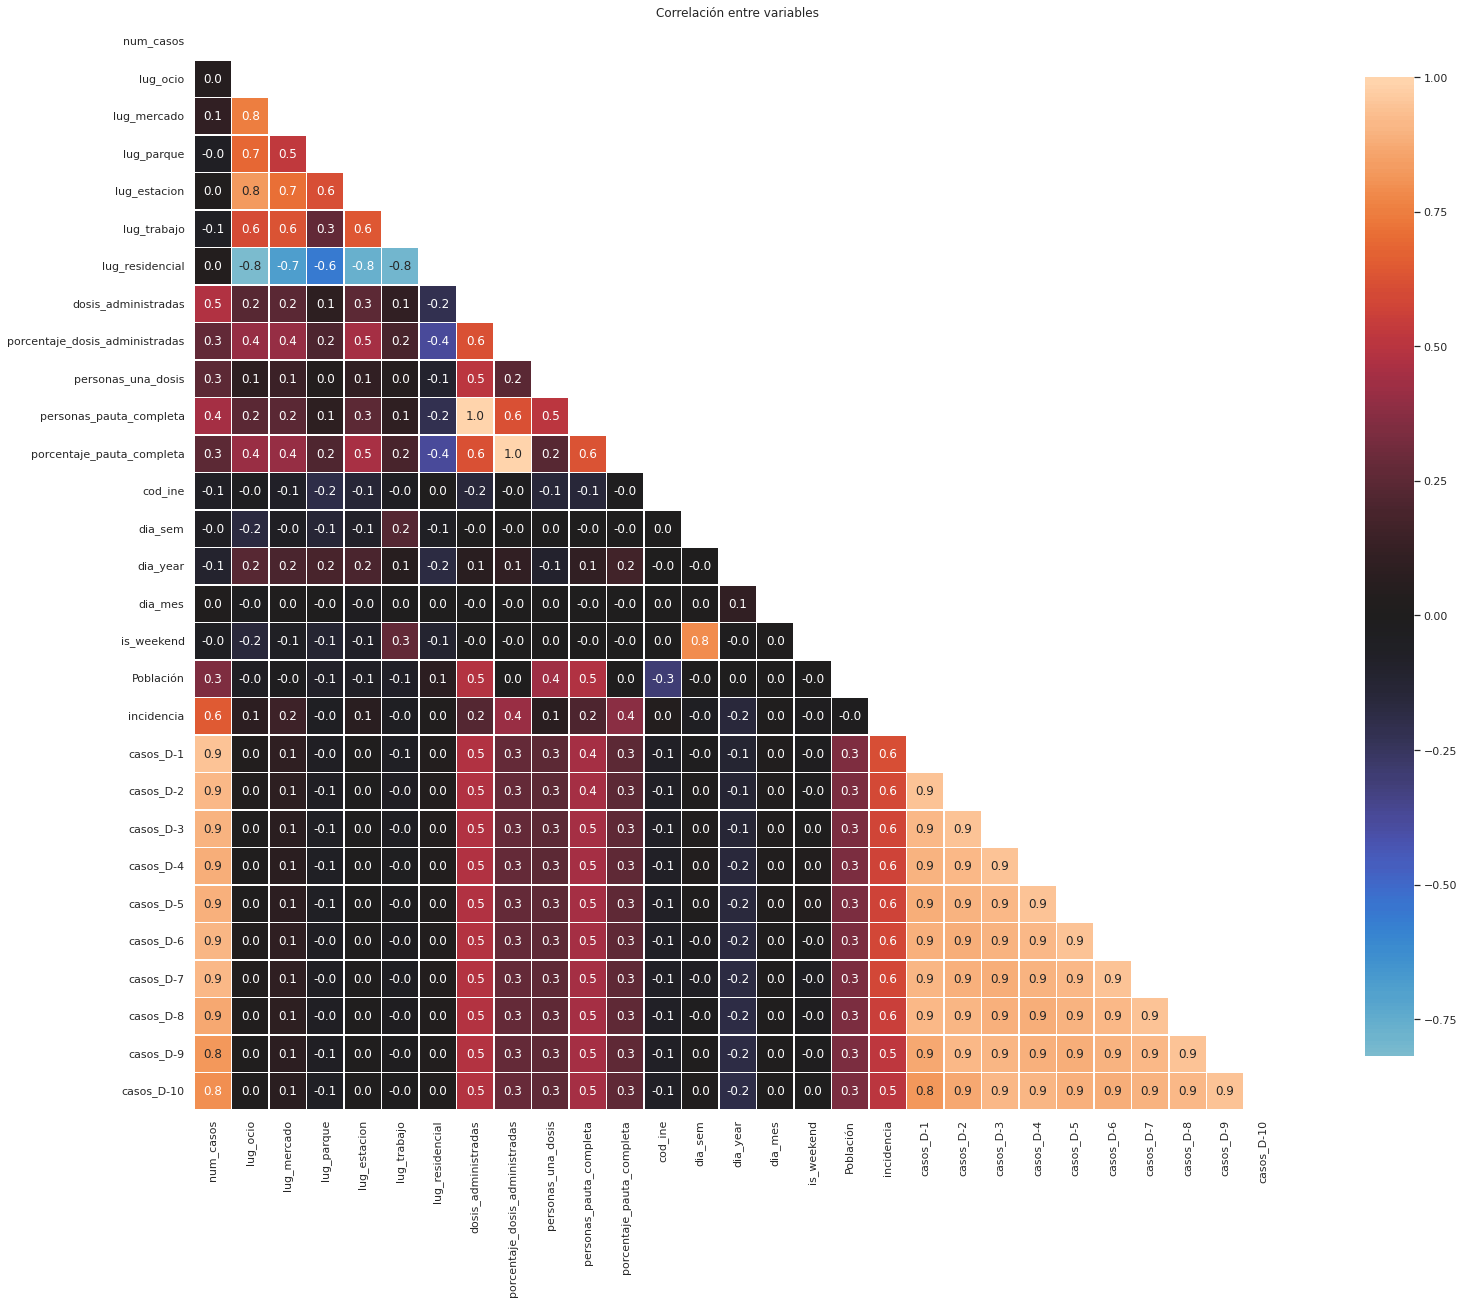

In [31]:
# comprobamos las correlaciones de los nuevos atributos
f, ax = plt.subplots(figsize=(30, 20))
corr = df1.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap="GnBu"
plt.title('Correlación entre variables')
sns.heatmap(corr, mask=mask, vmax=1, center=0,
            square=True, linewidths=.5,fmt='.1f',cbar_kws={"shrink": 0.9},ax=ax,annot=True)

In [22]:
# Creamos los df de trains y test para la iteración I

df_train_I=df1[df1['fecha'].isin (pd.date_range (train_ini,train_fin))]
df_test_I=df1[df1['fecha'].isin (pd.date_range (test_ini,test_fin))]

In [23]:
# definimos los modelos de árbol de decisiones
models=dict()
models['RF']= RandomForestRegressor(random_state=0, criterion='mae')
models['XGB']= XGBRegressor(eval_metric='mae',objective='reg:squarederror',random_state=0)
models['GB']= GradientBoostingRegressor(random_state=0,criterion='mae')
models['AB']= AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae'), random_state=0)

In [24]:
# calculamos los errores de esta iteración
models_fit_I, models_predict_I, models_error_I = evaluar_modelo(df_test_I, df_train_I, models)
df_models_error_I = pd.DataFrame(models_error_I).T
df_models_error_I

,MAE,RMSE,SCORE
RF,562.713,2474.127,0.599
XGB,596.839,2423.405,0.615
GB,610.863,2366.855,0.633
AB,624.473,2476.204,0.598


In [25]:
best_models_I = show_error_for_ca(y_pred_rfr=models_predict_I['RF'], y_pred_xgbr=models_predict_I['XGB'], 
                  y_pred_gbr=models_predict_I['GB'], y_pred_abr=models_predict_I['AB'], dataset=df1, 
                  test_ini=test_ini, test_fin=test_fin, df_ccaa=df_ccaa, criterion='rmse')

,nombre_ccaa,cod_ine,Modelo,MAE,RMSE,SCORE
1,Andalucía,1,XGBoost,523.325,1332.261,0.879
2,Aragón,2,RandomForest,205.364,447.212,0.939
3,Principado de Asturias,3,RandomForest,119.118,245.294,0.927
6,Cantabria,6,AdaBoost,65.291,136.253,0.948
18,Ceuta,18,RandomForest,13.838,29.518,0.919
7,Castilla-León,7,XGBoost,575.965,1125.88,0.833
8,Castilla-La Mancha,8,RandomForest,232.05,537.805,0.914
5,Canarias,5,RandomForest,310.948,630.958,0.827
9,Cataluña,9,GradientBoosting,3732.993,8541.848,0.337
11,Extremadura,11,RandomForest,187.077,389.387,0.853


In [73]:
df1.to_csv("df_iter1.csv", index=False)
files.download("df_iter1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Iteración II

In [56]:
mov_cols = [ 'lug_ocio', 'lug_mercado', 'lug_parque',
       'lug_estacion', 'lug_trabajo', 'lug_residencial']

In [62]:
df2_corr = df[df.columns]
for i in [7, 14, 21, 28]:
  for c in mov_cols:
    col = f"{c}_D-{i}"
    df2_corr[col] = df2_corr.groupby(['cod_ine'])[c].shift(i)

df2_corr.fillna(0, inplace=True)

In [64]:
df2_corr

,ccaa_iso,fecha,num_casos,lug_ocio,lug_mercado,lug_parque,lug_estacion,lug_trabajo,lug_residencial,dosis_administradas,...,lug_parque_D-21,lug_estacion_D-21,lug_trabajo_D-21,lug_residencial_D-21,lug_ocio_D-28,lug_mercado_D-28,lug_parque_D-28,lug_estacion_D-28,lug_trabajo_D-28,lug_residencial_D-28
0,ES-AN,2020-01-31,0,5.0,-1.0,33.0,15.000000,0.0,-2.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ES-AR,2020-01-31,0,3.0,7.0,42.0,10.000000,1.0,-3.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ES-AS,2020-01-31,0,0.0,-1.0,20.0,8.000000,0.0,-1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ES-CB,2020-01-31,0,6.0,4.0,53.0,4.000000,-1.0,-2.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ES-CE,2020-01-31,0,-3.0,-6.0,3.0,-39.602941,-1.0,10.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14720,ES-ML,2022-03-15,11,-23.0,-11.0,-45.0,-22.000000,-14.0,5.000000,136751.0,...,-15.0,7.0,-13.0,3.0,-12.0,-5.0,-14.0,7.0,-15.0,3.0
14721,ES-NC,2022-03-15,269,-18.0,10.0,11.0,-14.000000,-2.0,2.000000,1291695.0,...,24.0,-3.0,-2.0,0.0,-11.0,14.0,8.0,-6.0,-4.0,1.0
14722,ES-PV,2022-03-15,0,-23.0,5.0,7.0,-14.000000,-11.0,3.000000,4343580.0,...,38.0,-5.0,-12.0,1.0,-14.0,13.0,16.0,-7.0,-13.0,2.0
14723,ES-RI,2022-03-15,0,-21.0,10.0,-16.0,-13.000000,-3.0,2.000000,627460.0,...,14.0,-1.0,-3.0,-1.0,-10.0,15.0,2.0,-5.0,-4.0,0.0


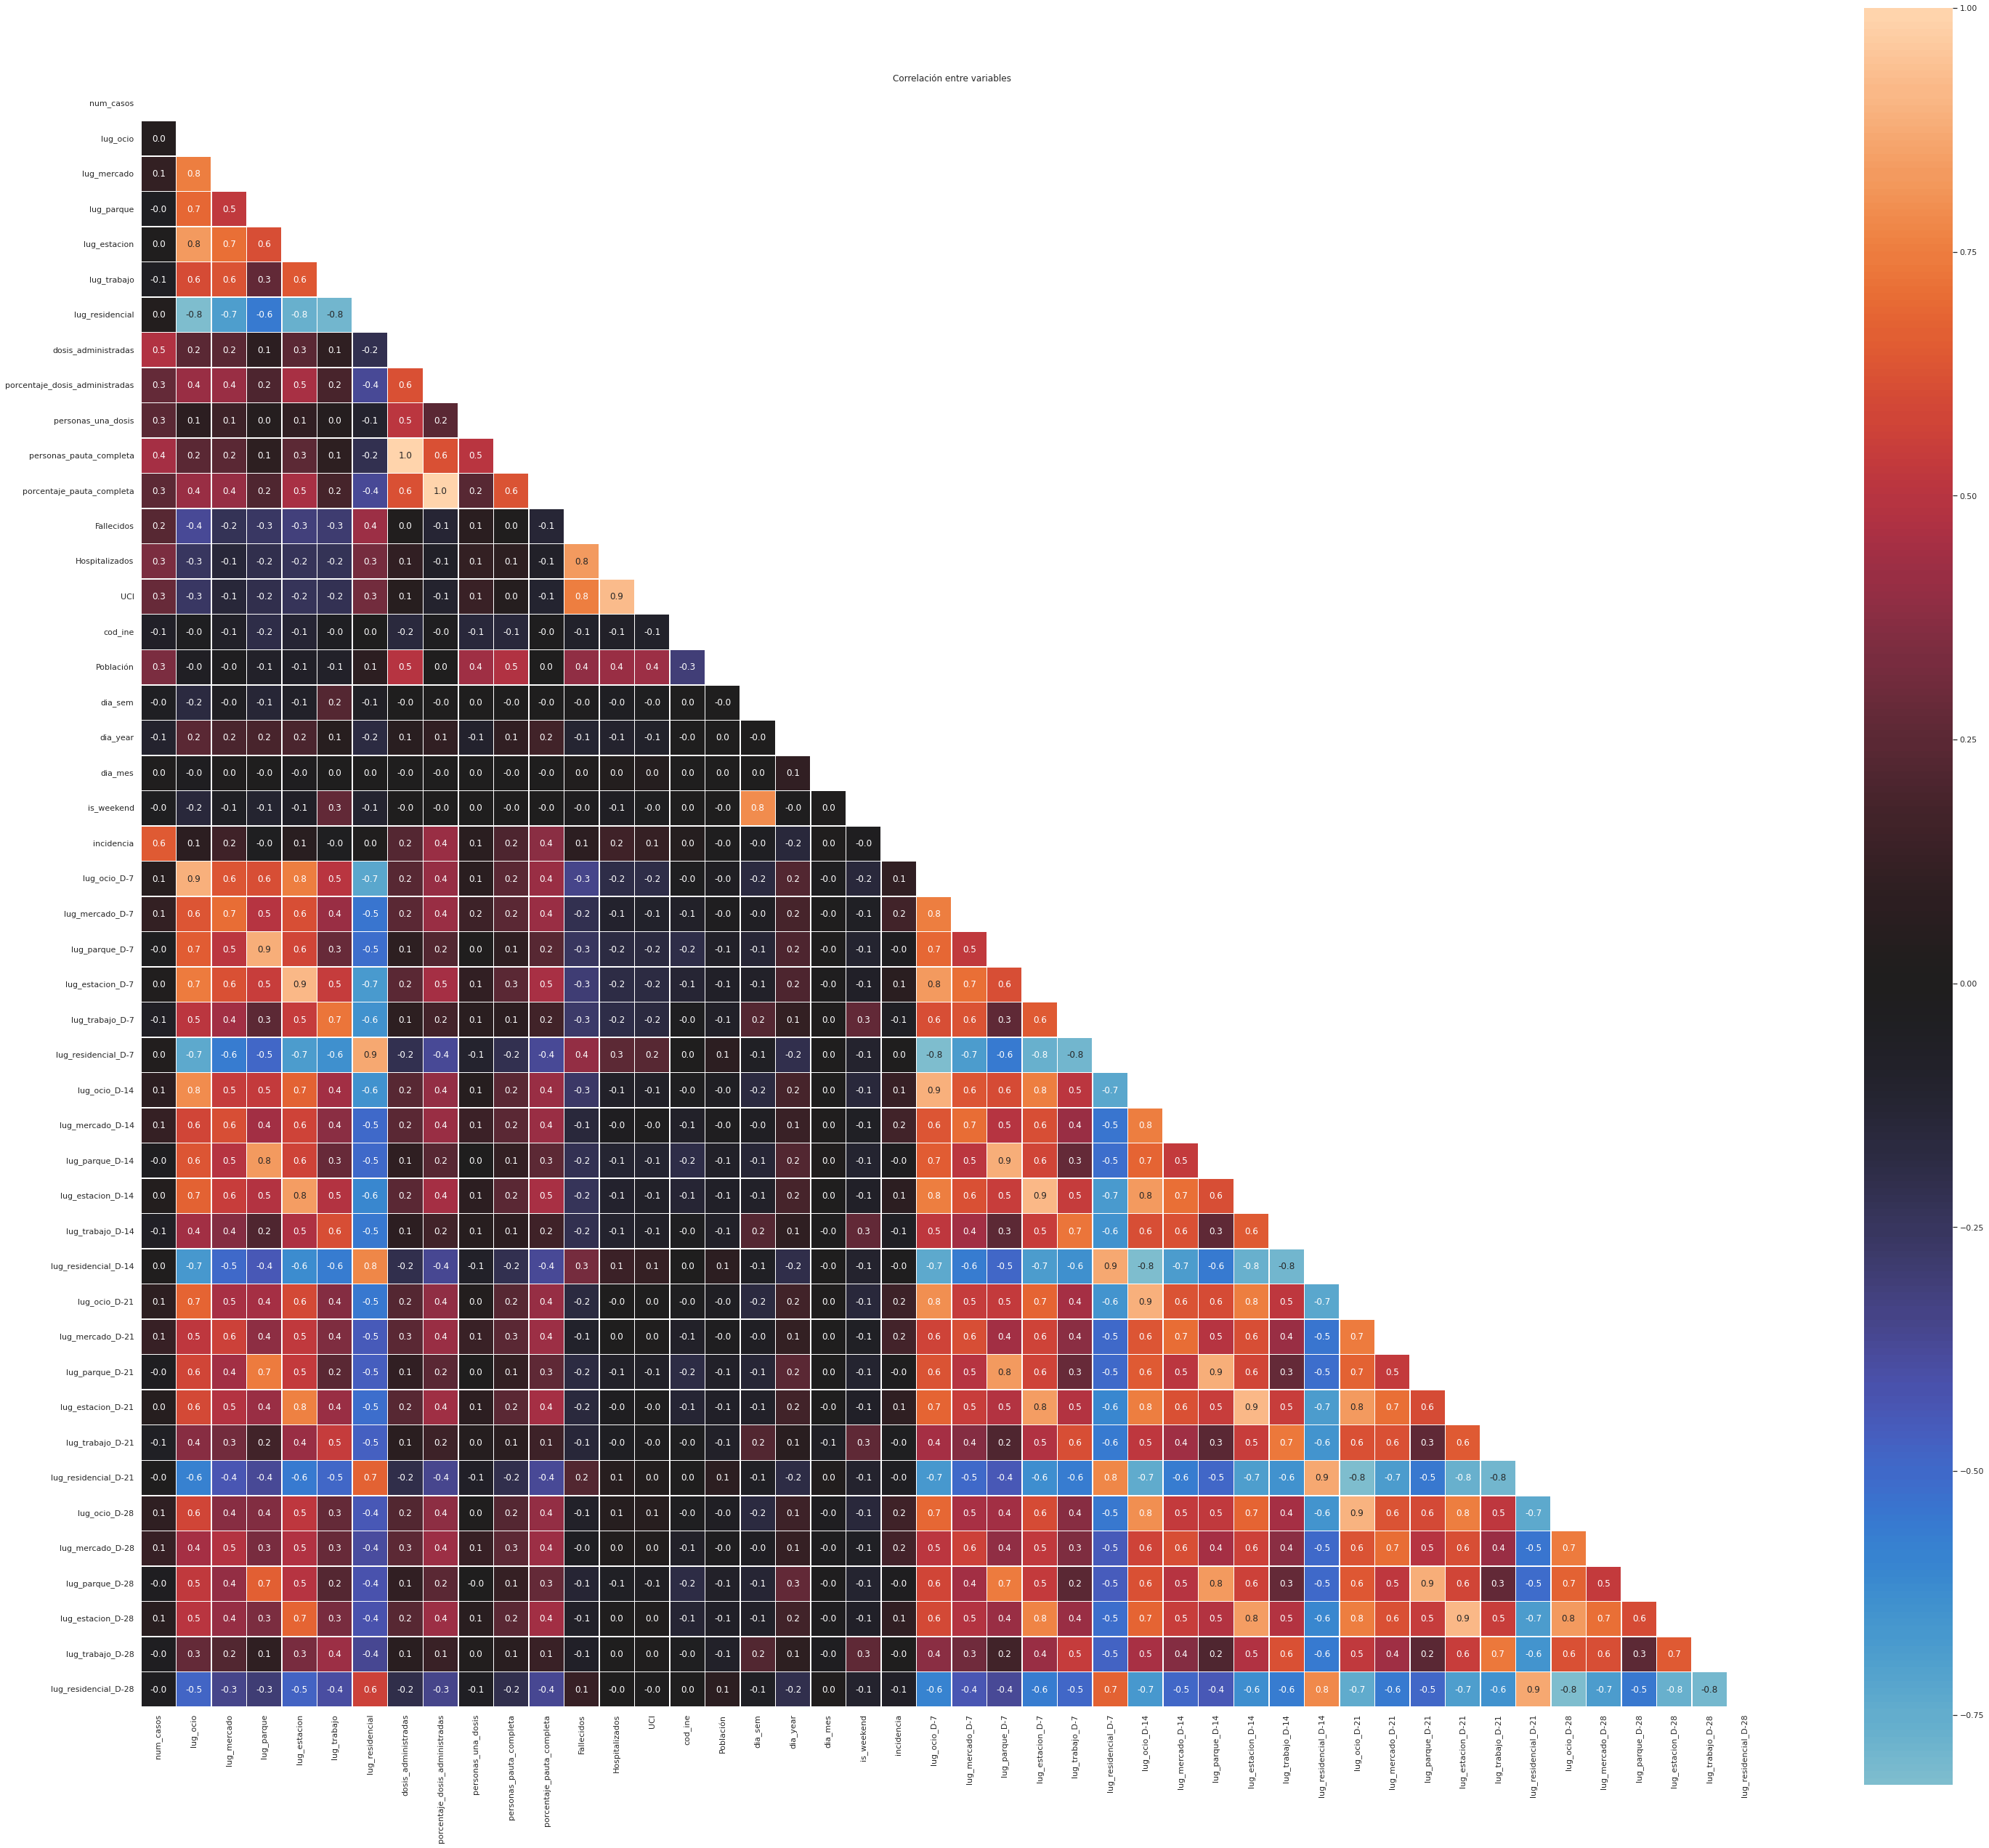

In [65]:
# calculamos la correlación de las variables
# comprobamos las correlaciones de los nuevos atributos
f, ax = plt.subplots(figsize=(50, 50))
corr = df2_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap="GnBu"
plt.title('Correlación entre variables')
sns.heatmap(corr, mask=mask, vmax=1, center=0,
            square=True, linewidths=.5,fmt='.1f',cbar_kws={"shrink": 0.9},ax=ax,annot=True)

In [57]:
df2 = df1[df1.columns]
for i in [7, 14, 21, 28]:
  for c in mov_cols:
    col = f"{c}_D-{i}"
    df2[col] = df2.groupby(['cod_ine'])[c].shift(i)

df2.fillna(0, inplace=True)
df2.columns

Index(['fecha', 'num_casos', 'lug_ocio', 'lug_mercado', 'lug_parque',
       'lug_estacion', 'lug_trabajo', 'lug_residencial', 'dosis_administradas',
       'porcentaje_dosis_administradas', 'personas_una_dosis',
       'personas_pauta_completa', 'porcentaje_pauta_completa', 'cod_ine',
       'dia_sem', 'dia_year', 'dia_mes', 'is_weekend', 'Población',
       'incidencia', 'casos_D-1', 'casos_D-2', 'casos_D-3', 'casos_D-4',
       'casos_D-5', 'casos_D-6', 'casos_D-7', 'casos_D-8', 'casos_D-9',
       'casos_D-10', 'lug_ocio_D-7', 'lug_mercado_D-7', 'lug_parque_D-7',
       'lug_estacion_D-7', 'lug_trabajo_D-7', 'lug_residencial_D-7',
       'lug_ocio_D-14', 'lug_mercado_D-14', 'lug_parque_D-14',
       'lug_estacion_D-14', 'lug_trabajo_D-14', 'lug_residencial_D-14',
       'lug_ocio_D-21', 'lug_mercado_D-21', 'lug_parque_D-21',
       'lug_estacion_D-21', 'lug_trabajo_D-21', 'lug_residencial_D-21',
       'lug_ocio_D-28', 'lug_mercado_D-28', 'lug_parque_D-28',
       'lug_estacion_D-2

In [32]:
df2.columns

Index(['fecha', 'num_casos', 'lug_ocio', 'lug_mercado', 'lug_parque',
       'lug_estacion', 'lug_trabajo', 'lug_residencial', 'dosis_administradas',
       'porcentaje_dosis_administradas', 'personas_una_dosis',
       'personas_pauta_completa', 'porcentaje_pauta_completa', 'cod_ine',
       'dia_sem', 'dia_year', 'dia_mes', 'is_weekend', 'Población',
       'incidencia', 'casos_D-1', 'casos_D-2', 'casos_D-3', 'casos_D-4',
       'casos_D-5', 'casos_D-6', 'casos_D-7', 'casos_D-8', 'casos_D-9',
       'casos_D-10', 'lug_ocio_D-7', 'lug_mercado_D-7', 'lug_parque_D-7',
       'lug_estacion_D-7', 'lug_trabajo_D-7', 'lug_residencial_D-7',
       'lug_ocio_D-14', 'lug_mercado_D-14', 'lug_parque_D-14',
       'lug_estacion_D-14', 'lug_trabajo_D-14', 'lug_residencial_D-14',
       'lug_ocio_D-21', 'lug_mercado_D-21', 'lug_parque_D-21',
       'lug_estacion_D-21', 'lug_trabajo_D-21', 'lug_residencial_D-21',
       'lug_ocio_D-28', 'lug_mercado_D-28', 'lug_parque_D-28',
       'lug_estacion_D-2

In [33]:
df2.to_csv("df_iter2.csv", index=False)
files.download("df_iter2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
# definimos los modelos de árbol de decisiones
models=dict()
models['RF']= RandomForestRegressor(random_state=0, criterion='mae')
models['XGB']= XGBRegressor(eval_metric='mae',objective='reg:squarederror',random_state=0)
models['GB']= GradientBoostingRegressor(random_state=0,criterion='mae')
models['AB']= AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae'), random_state=0)

In [59]:
# Creamos los df de trains y test para la iteración I

df_train_II=df2[df2['fecha'].isin (pd.date_range (train_ini,train_fin))]
df_test_II=df2[df2['fecha'].isin (pd.date_range (test_ini,test_fin))]

# calculamos los errores de esta iteración
models_fit_II, models_predict_II, models_error_II = evaluar_modelo(df_test_II, df_train_II, models)

In [60]:
df_models_error_II = pd.DataFrame(models_error_II).T
df_models_error_II

,MAE,RMSE,SCORE
RF,571.193,2500.379,0.590
XGB,603.370,2452.056,0.606
GB,614.552,2452.487,0.606
AB,601.832,2517.056,0.585


In [61]:
best_models_II = show_error_for_ca(y_pred_rfr=models_predict_II['RF'], y_pred_xgbr=models_predict_II['XGB'], 
                  y_pred_gbr=models_predict_II['GB'], y_pred_abr=models_predict_II['AB'], dataset=df2, 
                  test_ini=test_ini, test_fin=test_fin, df_ccaa=df_ccaa, criterion='rmse')

,nombre_ccaa,cod_ine,Modelo,MAE,RMSE,SCORE
1,Andalucía,1,GradientBoosting,562.557,1419.825,0.863
2,Aragón,2,RandomForest,193.795,425.916,0.944
3,Principado de Asturias,3,AdaBoost,109.26,226.924,0.937
6,Cantabria,6,AdaBoost,69.179,143.527,0.942
18,Ceuta,18,RandomForest,13.799,28.82,0.923
7,Castilla-León,7,XGBoost,575.877,1113.392,0.837
8,Castilla-La Mancha,8,RandomForest,231.619,547.776,0.91
5,Canarias,5,RandomForest,318.228,654.646,0.813
9,Cataluña,9,XGBoost,3834.678,8821.445,0.292
11,Extremadura,11,AdaBoost,183.791,376.426,0.862


# optimización de hiperparámetros

In [29]:
df1['fecha'] = pd.to_datetime(df1['fecha'],format='%Y-%m-%d')
min_fecha=df1.fecha.min()
max_fecha=df1.fecha.max()
train_ini = min_fecha
train_fin = '2021-08-31'
test_ini = '2021-09-01'
test_fin = max_fecha
df_train=df1[df1['fecha'].isin (pd.date_range (train_ini,train_fin))]
df_test=df1[df1['fecha'].isin (pd.date_range (test_ini,test_fin))]

In [28]:
def get_errors (real,predict, name_col=''):
    #bias = np.mean(real - predict)
    mae= metrics.mean_absolute_error(real, predict)
    #mse=metrics.mean_squared_error(real, predict)
    rmse= np.sqrt (metrics.mean_squared_error(real, predict))   
    #mape = np.mean(np.abs((real - predict) / real) * 100)   
    score= metrics.r2_score(real,predict) 
    
    df = pd.DataFrame([mae, rmse, score], index=['MAE','RMSE','SCORE'], columns=[name_col])
    return df.T

In [27]:
# Funciones 
def grid_search(df_train, df_test, model, param, title, 
                show_features_importance=True, n_splits=3):
    X_train, y_train, X_test, y_test =split_dataset_train_test(df_train, df_test)
    tscv = TimeSeriesSplit(n_splits=n_splits)
    grid = GridSearchCV(estimator = model, param_grid=param, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')
    grid.fit(X = X_train,y=y_train)
    #report(grid.cv_results_)
    best_params = grid.best_params_
    for i in best_params:
        print (i, ":", best_params[i])
    fit_model= grid.best_estimator_
    y_pred=fit_model.predict (X_test)
    error_test=get_errors(y_test, y_pred,title)
    display (error_test)
    return (fit_model, y_pred)


def random_search(df_train, df_test, model, param, title, 
                  show_features_importance=True, n_splits=3):

    X_train, y_train, X_test, y_test =split_dataset_train_test(df_train, df_test)
    tscv = TimeSeriesSplit(n_splits=n_splits)
    random= RandomizedSearchCV(estimator = model, param_distributions = param, n_iter = 50, scoring='neg_mean_squared_error',cv = tscv, random_state=0, n_jobs = -1)
    random.fit(X = X_train,y=y_train)
    #report(grid.cv_results_, n_top = 5)
    best_params = random.best_params_
    for i in best_params:
        print (i, ":", best_params[i])
    fit_model= random.best_estimator_
    y_pred=fit_model.predict (X_test)
    error_test=get_errors(y_test, y_pred,title)
    display (error_test)
    return (fit_model, y_pred)

## Random Search

In [30]:

hyperparam = {"n_estimators": [64, 128, 150], 
              "max_depth": [4, 6, 8], 
              "min_samples_split": [2, 4, 6], 
              "min_samples_leaf": [ 12, 14, 16, 18], 
              "bootstrap": [True, False] 
             }
model = RandomForestRegressor(criterion='mse', random_state=0)
title = 'RandomForest'
rfr_random_search,predict_rfr_random_search = random_search(df_train=df_train, 
                                                  df_test=df_test, model=model, 
                                                  param=hyperparam, 
                                                  title='RandomForest')

n_estimators : 150
min_samples_split : 6
min_samples_leaf : 12
max_depth : 8
bootstrap : False


,MAE,RMSE,SCORE
RandomForest,655.28898,2508.421651,0.587459


In [31]:
rfr_random_search

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=8,
                      min_samples_leaf=12, min_samples_split=6,
                      n_estimators=150, random_state=0)

In [32]:

hyperparam = {'n_estimators': [100,300,500],
              'max_depth':range(1,6),
              'min_child_weight':range(1,5),
              'subsample': [i / 10.0 for i in range(6, 9)],
              'colsample_bytree': [i / 10.0 for i in range(6, 11)],   
              'eta': [.3, .2, .1, .05, .01, .005],
              'gamma':[i/10.0 for i in range(0,6)]   
             }
model = XGBRegressor(eval_metric='rmse',objective='reg:squarederror', random_state=0)
title = 'XGBoost'
xgb_random_search,predict_xbg_random_search = random_search(df_train=df_train, 
                                                  df_test=df_test, model=model, 
                                                  param=hyperparam, 
                                                  title=title)

subsample : 0.6
n_estimators : 500
min_child_weight : 4
max_depth : 5
gamma : 0.1
eta : 0.3
colsample_bytree : 1.0


,MAE,RMSE,SCORE
XGBoost,558.794638,2412.458118,0.61842


In [33]:
xgb_random_search

XGBRegressor(colsample_bytree=1.0, eta=0.3, eval_metric='rmse', gamma=0.1,
             max_depth=5, min_child_weight=4, n_estimators=500,
             objective='reg:squarederror', subsample=0.6)

In [34]:
# este
hyperparam = {
 "n_estimators": [16, 32, 64, 100, 128, 200, 256],
 "learning_rate" : [0.01, 0.05, 0.75, 0.1, 0.15, 0.2, 0.25,0.5],
 "max_features" : ["auto", "sqrt"],
 "min_samples_split": [2, 4, 6, 8, 10],
 'max_depth': range(3,10,2),
 "loss" : ['ls', 'lad'],
 'warm_start':[True, False]
 }
model = GradientBoostingRegressor(criterion='mse', random_state=0)
title = 'GradientBoosting'

gbr_random_search,predict_gbr_random_search = random_search(df_train=df_train, 
                                                  df_test=df_test, model=model, 
                                                  param=hyperparam, 
                                                  title=title)

warm_start : True
n_estimators : 200
min_samples_split : 4
max_features : auto
max_depth : 3
loss : ls
learning_rate : 0.25


,MAE,RMSE,SCORE
GradientBoosting,565.331674,2375.268158,0.630094


In [35]:
gbr_random_search

GradientBoostingRegressor(criterion='mse', learning_rate=0.25, loss='ls',
                          max_features='auto', min_samples_split=4,
                          n_estimators=200, random_state=0, warm_start=True)

In [36]:
# este
hyperparam = {
 "n_estimators": [8, 16, 32, 64, 70, 80, 90, 100, 128],
 "learning_rate" : [0.005, 0.01, 0.015, 0.02, 0.025, 0.05, 0.1],
 "loss" : ['linear', 'square', 'exponential']
 }

model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse'),random_state=0)
title = 'AdaBoost'

abr_random_search,predict_abr_random_search = random_search(df_train=df_train, 
                                                  df_test=df_test, model=model, 
                                                  param=hyperparam, 
                                                  title=title)

n_estimators : 90
loss : linear
learning_rate : 0.05


,MAE,RMSE,SCORE
AdaBoost,567.853383,2423.531586,0.614909


In [37]:
abr_random_search

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse'),
                  learning_rate=0.05, n_estimators=90, random_state=0)

In [80]:
# calculamos el error por comunidad con los mejores hiperparámetros
best_models_ccaa_hiper = show_error_for_ca(models_predict_I['RF'], 
                                           models_predict_I['XGB'] ,
                                           models_predict_I['GB'], 
                                           models_predict_I['AB'], 
                                           df1, 
                                           test_ini, 
                                           test_fin, 
                                           df_ccaa, 
                                           criterion='rmse')

,nombre_ccaa,cod_ine,Modelo,MAE,RMSE,SCORE
1,Andalucía,1,XGBoost,523.325,1332.261,0.879
2,Aragón,2,RandomForest,205.364,447.212,0.939
3,Principado de Asturias,3,RandomForest,119.118,245.294,0.927
6,Cantabria,6,AdaBoost,65.291,136.253,0.948
18,Ceuta,18,RandomForest,13.838,29.518,0.919
7,Castilla-León,7,XGBoost,575.965,1125.88,0.833
8,Castilla-La Mancha,8,RandomForest,232.05,537.805,0.914
5,Canarias,5,RandomForest,310.948,630.958,0.827
9,Cataluña,9,GradientBoosting,3732.993,8541.848,0.337
11,Extremadura,11,RandomForest,187.077,389.387,0.853


In [38]:
# calculamos el error por comunidad con los mejores hiperparámetros
best_models_ccaa_hiper = show_error_for_ca(models_predict_I['RF'], 
                                           predict_xbg_random_search, 
                                           predict_gbr_random_search, 
                                           predict_abr_random_search, 
                                           df1, 
                                           test_ini, 
                                           test_fin, 
                                           df_ccaa, 
                                           criterion='rmse')

,nombre_ccaa,cod_ine,Modelo,MAE,RMSE,SCORE
1,Andalucía,1,GradientBoosting,448.171,1191.837,0.903
2,Aragón,2,RandomForest,205.364,447.212,0.939
3,Principado de Asturias,3,AdaBoost,112.077,232.819,0.934
6,Cantabria,6,RandomForest,69.779,153.312,0.934
18,Ceuta,18,RandomForest,13.838,29.518,0.919
7,Castilla-León,7,XGBoost,506.592,1066.073,0.85
8,Castilla-La Mancha,8,RandomForest,232.05,537.805,0.914
5,Canarias,5,RandomForest,310.948,630.958,0.827
9,Cataluña,9,GradientBoosting,3636.233,8538.635,0.337
11,Extremadura,11,AdaBoost,187.684,363.157,0.872


## Grid Search

In [82]:
hyperparam = {"n_estimators": [16, 64, 128, 256, 512], 
              "max_depth": [4,6,8,10], 
              "min_samples_split": [2, 4, 6, 8], 
              "min_samples_leaf": [10, 12,16,18,20], 
              "bootstrap": [True, False] 
             }
model = RandomForestRegressor(criterion='mse', random_state=0)
title = 'RandomForest'
rfr_tune_grid,predict_rfr_tune_grid= grid_search(df_train=df_train, 
                                                  df_test=df_test, model=model, 
                                                  param=hyperparam, 
                                                  title='RandomForest')

bootstrap : False
max_depth : 8
min_samples_leaf : 10
min_samples_split : 2
n_estimators : 512


,MAE,RMSE,SCORE
RandomForest,649.896325,2505.765794,0.588333


In [ ]:
hyperparam = {"n_estimators": [64, 128, 150], 
              "max_depth": [4, 6, 8], 
              "min_samples_split": [2, 4, 6], 
              "min_samples_leaf": [ 12, 14, 16, 18], 
              "bootstrap": [True, False] 
             }
model = RandomForestRegressor(criterion='mse', random_state=0)
title = 'RandomForest'
rfr_tune_grid2,predict_rfr_tune_grid2= grid_search(df_train=df_train, 
                                                  df_test=df_test, model=model, 
                                                  param=hyperparam, 
                                                  title='RandomForest')

In [ ]:
# este
hyperparam = {'n_estimators': [100,200,300,400,500],
              'max_depth':range(1,10),
              'min_child_weight':range(1,5),
              'subsample': [i / 10.0 for i in range(6, 9)],
              'colsample_bytree': [i / 10.0 for i in range(6, 11)],   
              'eta': [.3, .2, .1, .05, .01, .005],
              'gamma':[i/10.0 for i in range(0,6)]   
             }
# hyperparam = {
#     'n_estimators': [100,200,300,400,500],
#     'max_depth':range(1,10),
#     'min_child_weight':range(1,5)
# }
model = XGBRegressor(eval_metric='rmse',objective='reg:squarederror', random_state=0)
title = 'XGBoost'
xgb_grid_search,predict_xbg_grid_search = grid_search(df_train=df_train, 
                                                  df_test=df_test, model=model, 
                                                  param=hyperparam, 
                                                  title=title)

In [ ]:
# este
hyperparam = {
 "n_estimators": [16, 32, 64, 100, 128, 200, 256],
 "learning_rate" : [0.01, 0.05, 0.75, 0.1, 0.15, 0.2, 0.25,0.5],
 "max_features" : ["auto", "sqrt"],
 "min_samples_split": [2, 4, 6, 8, 10],
 'max_depth': range(3,10,2),
 "loss" : ['ls', 'lad'],
 'warm_start':[True, False]
 }
model = GradientBoostingRegressor(criterion='mse', random_state=0)
title = 'GradientBoosting'

gbr_grid_search,predict_gbr_grid_search = grid_search(df_train=df_train, 
                                                  df_test=df_test, model=model, 
                                                  param=hyperparam, 
                                                  title=title)

In [ ]:
# este
hyperparam = {
 "n_estimators": [8, 16, 32, 64, 70, 80, 90, 100, 128],
 "learning_rate" : [0.005, 0.01, 0.015, 0.02, 0.025, 0.05, 0.1],
 "loss" : ['linear', 'square', 'exponential']
 }

model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse'),random_state=0)
title = 'AdaBoost'

abr_grid_search,predict_abr_grid_search = grid_search(df_train=df_train, 
                                                  df_test=df_test, model=model, 
                                                  param=hyperparam, 
                                                  title=title)

In [ ]:
df1.columns

Index(['fecha', 'num_casos', 'lug_ocio', 'lug_mercado', 'lug_parque',
       'lug_estacion', 'lug_trabajo', 'lug_residencial', 'dosis_administradas',
       'porcentaje_dosis_administradas', 'personas_una_dosis',
       'personas_pauta_completa', 'porcentaje_pauta_completa', 'Fallecidos',
       'Hospitalizados', 'UCI', 'cod_ine', 'dia_sem', 'dia_year', 'dia_mes',
       'is_weekend', 'casos_D-1', 'casos_D-2', 'casos_D-3', 'casos_D-4',
       'casos_D-5', 'casos_D-6', 'casos_D-7', 'casos_D-8', 'casos_D-9',
       'casos_D-10'],
      dtype='object')

# Resultados

In [39]:
df_result=df1.copy()
df_result_train=df_result[df_result['fecha'].isin (pd.date_range (train_ini,train_fin))]
df_result_test=df_result[df_result['fecha'].isin (pd.date_range (test_ini,test_fin))]

df = df_result_test.copy()
df

,fecha,num_casos,lug_ocio,lug_mercado,lug_parque,lug_estacion,lug_trabajo,lug_residencial,dosis_administradas,porcentaje_dosis_administradas,...,casos_D-1,casos_D-2,casos_D-3,casos_D-4,casos_D-5,casos_D-6,casos_D-7,casos_D-8,casos_D-9,casos_D-10
11001,2021-09-01,824,5.0,21.0,47.0,0.0,-23.0,2.0,11970705.0,141.12,...,952,855,563,753,1131,1153,1351,1445,1523,868
11002,2021-09-01,191,-10.0,23.0,38.0,-8.0,-23.0,4.0,1875387.0,140.87,...,174,189,121,140,178,177,234,249,237,183
11003,2021-09-01,24,-2.0,20.0,134.0,10.0,-24.0,1.0,1592065.0,156.79,...,31,57,54,54,42,38,54,57,74,56
11004,2021-09-01,76,22.0,49.0,198.0,30.0,-13.0,2.0,824567.0,141.59,...,73,74,81,96,114,88,108,108,154,127
11005,2021-09-01,18,0.0,4.0,40.0,-60.0,-32.0,0.0,103814.0,123.59,...,18,13,18,14,14,18,44,20,50,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14720,2022-03-15,11,-23.0,-11.0,-45.0,-22.0,-14.0,5.0,136751.0,162.25,...,12,19,9,6,12,20,13,11,12,14
14721,2022-03-15,269,-18.0,10.0,11.0,-14.0,-2.0,2.0,1291695.0,196.54,...,342,198,121,269,313,271,239,270,222,130
14722,2022-03-15,0,-23.0,5.0,7.0,-14.0,-11.0,3.0,4343580.0,198.38,...,0,12,863,438,462,809,910,663,801,818
14723,2022-03-15,0,-21.0,10.0,-16.0,-13.0,-3.0,2.0,627460.0,198.48,...,1,2,173,62,80,182,223,127,92,152


In [40]:
df['XGBoost']=predict_xbg_random_search
df['AdaBoost']= predict_abr_random_search
df['RandomForest']=models_predict_I['RF']
df['GradientBoosting']=predict_gbr_random_search
df 

,fecha,num_casos,lug_ocio,lug_mercado,lug_parque,lug_estacion,lug_trabajo,lug_residencial,dosis_administradas,porcentaje_dosis_administradas,...,casos_D-5,casos_D-6,casos_D-7,casos_D-8,casos_D-9,casos_D-10,XGBoost,AdaBoost,RandomForest,GradientBoosting
11001,2021-09-01,824,5.0,21.0,47.0,0.0,-23.0,2.0,11970705.0,141.12,...,1131,1153,1351,1445,1523,868,870.176575,821.0,804.74,874.394721
11002,2021-09-01,191,-10.0,23.0,38.0,-8.0,-23.0,4.0,1875387.0,140.87,...,178,177,234,249,237,183,186.501709,183.0,182.56,169.959122
11003,2021-09-01,24,-2.0,20.0,134.0,10.0,-24.0,1.0,1592065.0,156.79,...,42,38,54,57,74,56,33.526051,36.0,42.28,25.538787
11004,2021-09-01,76,22.0,49.0,198.0,30.0,-13.0,2.0,824567.0,141.59,...,114,88,108,108,154,127,93.268410,76.0,82.51,79.329436
11005,2021-09-01,18,0.0,4.0,40.0,-60.0,-32.0,0.0,103814.0,123.59,...,14,18,44,20,50,17,16.441982,18.0,18.87,15.621441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14720,2022-03-15,11,-23.0,-11.0,-45.0,-22.0,-14.0,5.0,136751.0,162.25,...,12,20,13,11,12,14,6.133163,11.0,11.44,-1.032536
14721,2022-03-15,269,-18.0,10.0,11.0,-14.0,-2.0,2.0,1291695.0,196.54,...,313,271,239,270,222,130,312.358948,325.0,343.26,307.423018
14722,2022-03-15,0,-23.0,5.0,7.0,-14.0,-11.0,3.0,4343580.0,198.38,...,462,809,910,663,801,818,81.986023,0.0,0.11,106.598418
14723,2022-03-15,0,-21.0,10.0,-16.0,-13.0,-3.0,2.0,627460.0,198.48,...,80,182,223,127,92,152,9.243958,0.0,0.00,-2.224372


In [41]:
result_collection = {}

for ca in df['cod_ine'].unique():
    df_ca=df[df['cod_ine']==ca]
    model_for_ca=best_models_ccaa_hiper[best_models_ccaa_hiper['cod_ine']==ca]['Modelo'].values[0]
    df_ca['predict']= df_ca[model_for_ca]

    result_collection[ca]=df_ca
# result_collection

In [43]:
df_result_test = pd.DataFrame()
for i in range (1,20):
    df_result_test =pd.concat ([df_result_test,result_collection[i]],axis=0)
df_result_test

,fecha,num_casos,lug_ocio,lug_mercado,lug_parque,lug_estacion,lug_trabajo,lug_residencial,dosis_administradas,porcentaje_dosis_administradas,...,casos_D-6,casos_D-7,casos_D-8,casos_D-9,casos_D-10,XGBoost,AdaBoost,RandomForest,GradientBoosting,predict
11001,2021-09-01,824,5.0,21.0,47.0,0.0,-23.0,2.0,11970705.0,141.12,...,1153,1351,1445,1523,868,870.176575,821.0,804.74,874.394721,874.394721
11020,2021-09-02,679,5.0,19.0,50.0,-2.0,-23.0,2.0,12028505.0,141.80,...,1131,1153,1351,1445,1523,681.030396,654.0,656.10,735.266826,735.266826
11039,2021-09-03,656,-2.0,12.0,44.0,-3.0,-21.0,1.0,12102296.0,142.67,...,753,1131,1153,1351,1445,655.586609,618.0,620.60,687.251014,687.251014
11058,2021-09-04,483,-10.0,5.0,42.0,0.0,-1.0,-2.0,12102296.0,142.67,...,563,753,1131,1153,1351,485.432007,555.0,540.77,529.253119,529.253119
11077,2021-09-05,381,-9.0,11.5,18.0,0.0,12.0,-3.0,12102296.0,142.67,...,855,563,753,1131,1153,395.836517,461.0,459.50,394.186321,394.186321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14644,2022-03-11,6,-18.0,-7.0,-33.0,1.0,-13.0,3.0,136751.0,162.25,...,14,8,1,13,24,3.762479,6.0,8.09,1.340334,8.090000
14663,2022-03-12,9,-14.0,-12.0,-26.0,2.0,-17.0,4.0,136751.0,162.25,...,12,14,8,1,13,3.892677,9.0,9.84,1.552335,9.840000
14682,2022-03-13,19,-14.0,-6.5,-37.0,3.0,-24.0,4.0,136751.0,162.25,...,11,12,14,8,1,4.025353,19.0,18.98,8.160849,18.980000
14701,2022-03-14,12,-19.0,-1.0,-38.0,4.0,-12.0,4.0,136751.0,162.25,...,13,11,12,14,8,14.571602,12.0,17.48,13.501962,17.480000


In [44]:
df_result_test.columns

Index(['fecha', 'num_casos', 'lug_ocio', 'lug_mercado', 'lug_parque',
       'lug_estacion', 'lug_trabajo', 'lug_residencial', 'dosis_administradas',
       'porcentaje_dosis_administradas', 'personas_una_dosis',
       'personas_pauta_completa', 'porcentaje_pauta_completa', 'cod_ine',
       'dia_sem', 'dia_year', 'dia_mes', 'is_weekend', 'Población',
       'incidencia', 'casos_D-1', 'casos_D-2', 'casos_D-3', 'casos_D-4',
       'casos_D-5', 'casos_D-6', 'casos_D-7', 'casos_D-8', 'casos_D-9',
       'casos_D-10', 'XGBoost', 'AdaBoost', 'RandomForest', 'GradientBoosting',
       'predict'],
      dtype='object')

In [45]:
df_result_test[['num_casos','predict']].describe().T

,count,mean,std,min,25%,50%,75%,max
num_casos,3724.0,1714.643394,3905.939775,0.0,71.0000,324.500,1528.500000,45922.000000
predict,3724.0,1382.048329,2226.242707,0.0,78.6925,342.525,1603.245853,10094.487408


In [46]:
df_medias =df_result_test.groupby('cod_ine')['num_casos','predict'].mean()
df_medias.rename (columns={'num_casos': 'media_casos', 'predict':'media_predict'}, inplace=True)
df_medias

,media_casos,media_predict
cod_ine,,
1,2966.923469,2610.845757
2,1260.301020,1240.159974
3,657.147959,648.785714
4,838.035714,872.771582
5,1132.153061,1122.191811
6,425.408163,452.184898
7,1890.408163,1960.529111
8,1233.250000,1207.874694
9,7221.035714,3681.620158


In [47]:
df_result.columns

Index(['fecha', 'num_casos', 'lug_ocio', 'lug_mercado', 'lug_parque',
       'lug_estacion', 'lug_trabajo', 'lug_residencial', 'dosis_administradas',
       'porcentaje_dosis_administradas', 'personas_una_dosis',
       'personas_pauta_completa', 'porcentaje_pauta_completa', 'cod_ine',
       'dia_sem', 'dia_year', 'dia_mes', 'is_weekend', 'Población',
       'incidencia', 'casos_D-1', 'casos_D-2', 'casos_D-3', 'casos_D-4',
       'casos_D-5', 'casos_D-6', 'casos_D-7', 'casos_D-8', 'casos_D-9',
       'casos_D-10'],
      dtype='object')

In [74]:
df_sum = df_result_test.groupby ('cod_ine')['num_casos','predict'].sum()
df_sum.rename (columns={'num_casos': 'casos_totales', 'predict':'casos_predic_totales'}, inplace=True)
df_sum

,casos_totales,casos_predic_totales
cod_ine,,
1,581517,511725.768383
2,247019,243071.355000
3,128801,127162.000000
4,164255,171063.230000
5,221902,219949.595000
6,83380,88628.240000
7,370520,384263.705669
8,241717,236743.440000
9,1415323,721597.551049


In [49]:
df_ccaa2 = df_ccaa.copy()
df_ccaa2.reset_index(inplace=True)
df_ccaa2

,cod_ine,cod_iso_ccaa,nombre_ccaa
0,1,ES-AN,Andalucía
1,2,ES-AR,Aragón
2,3,ES-AS,Principado de Asturias
3,5,ES-CN,Canarias
4,6,ES-CB,Cantabria
5,8,ES-CM,Castilla-La Mancha
6,7,ES-CL,Castilla-León
7,9,ES-CT,Cataluña
8,11,ES-EX,Extremadura
9,12,ES-GA,Galicia


In [50]:
df_sum = df_sum.reset_index(level=0)
df_sum.insert(0, 'nombre_ccaa', df_ccaa2['nombre_ccaa'][df_sum['cod_ine']-1])


In [53]:
df_sum

,nombre_ccaa,cod_ine,casos_totales,casos_predic_totales
0,Andalucía,1,581517,511725.768383
1,Aragón,2,247019,243071.355000
2,Principado de Asturias,3,128801,127162.000000
3,Canarias,4,164255,171063.230000
4,Cantabria,5,221902,219949.595000
5,Castilla-La Mancha,6,83380,88628.240000
6,Castilla-León,7,370520,384263.705669
7,Cataluña,8,241717,236743.440000
8,Extremadura,9,1415323,721597.551049
9,Galicia,10,817263,560047.000000


In [54]:
df_sum['Porcentaje diferencia casos'] = (df_sum['casos_totales']-df_sum['casos_predic_totales'])*100/df_sum['casos_totales']
df_sum

,nombre_ccaa,cod_ine,casos_totales,casos_predic_totales,Porcentaje diferencia casos
0,Andalucía,1,581517,511725.768383,12.001581
1,Aragón,2,247019,243071.355000,1.598114
2,Principado de Asturias,3,128801,127162.000000,1.272506
3,Canarias,4,164255,171063.230000,-4.144915
4,Cantabria,5,221902,219949.595000,0.879850
5,Castilla-La Mancha,6,83380,88628.240000,-6.294363
6,Castilla-León,7,370520,384263.705669,-3.709302
7,Cataluña,8,241717,236743.440000,2.057596
8,Extremadura,9,1415323,721597.551049,49.015345
9,Galicia,10,817263,560047.000000,31.472855


In [55]:
df_max=df_result_test.groupby ('cod_ine')['cod_ine', 'num_casos','predict'].max()
df_max.rename (columns={'num_casos': 'max_casos', 'predict':'max_predict'}, inplace=True)
df_max.insert(0, 'nombre_ccaa', df_ccaa['nombre_ccaa'][df_max['cod_ine']])
df_max.drop(columns=['cod_ine'], inplace=True)
df_max


,nombre_ccaa,max_casos,max_predict
cod_ine,,,
1,Andalucía,17261,10094.487408
2,Aragón,7178,7196.250000
3,Principado de Asturias,3816,2958.000000
4,Islas Baleares,4434,4139.470000
5,Canarias,6892,6966.690000
6,Cantabria,2352,2781.970000
7,Castilla-León,11535,7932.672363
8,Castilla-La Mancha,6957,7420.020000
9,Cataluña,45922,9976.375808


In [56]:
df_compare=pd.concat ([df_max, df_medias], axis=1)
df_compare['diff_media']=df_compare['media_casos']-df_compare['media_predict']
df_compare['diff_max']=df_compare['max_casos']-df_compare['max_predict']
df_compare

,nombre_ccaa,max_casos,max_predict,media_casos,media_predict,diff_media,diff_max
cod_ine,,,,,,,
1,Andalucía,17261,10094.487408,2966.923469,2610.845757,356.077712,7166.512592
2,Aragón,7178,7196.250000,1260.301020,1240.159974,20.141046,-18.250000
3,Principado de Asturias,3816,2958.000000,657.147959,648.785714,8.362245,858.000000
4,Islas Baleares,4434,4139.470000,838.035714,872.771582,-34.735867,294.530000
5,Canarias,6892,6966.690000,1132.153061,1122.191811,9.961250,-74.690000
6,Cantabria,2352,2781.970000,425.408163,452.184898,-26.776735,-429.970000
7,Castilla-León,11535,7932.672363,1890.408163,1960.529111,-70.120947,3602.327637
8,Castilla-La Mancha,6957,7420.020000,1233.250000,1207.874694,25.375306,-463.020000
9,Cataluña,45922,9976.375808,7221.035714,3681.620158,3539.415556,35945.624192


In [57]:
def plot_best_model (predict_rfr, predict_xgbr, predict_gbr, predict_abr, 
                     best_models,dataset):
    df = dataset[dataset['fecha'].isin (pd.date_range (test_ini,test_fin))]
    df['XGBoost']=predict_xgbr
    df['AdaBoost']=predict_abr
    df['RandomForest']= predict_rfr
    df['GradientBoosting']= predict_gbr

    #Calculamos filas y columnas del Grid
    n=df.cod_ine.nunique()
    ncols=2
    nfilas=math.ceil((n-ncols)/ncols)+1

    #Definimos la grid para representación
    fig= plt.figure(figsize=(20,42))
    gs = fig.add_gridspec(nfilas, ncols,hspace=0.4)

    #fig.suptitle('Predicción de casos por CA')
    nf,nc=0,0
    for ca in df['cod_ine'].unique():
        ax=fig.add_subplot(gs[nf,nc])

        x = df[df['cod_ine']== ca]['fecha']
        y1 = df[df['cod_ine']== ca]['num_casos'].cumsum()
        model_for_ca=best_models[best_models['cod_ine']==ca]['Modelo'].values[0]
        y2 = df[df['cod_ine']== ca][model_for_ca].cumsum()

        ax.plot (x, y1, label='Real',linewidth=2.5)
        ax.plot (x, y2, label =model_for_ca,linewidth=2.5)
        ax.set_ylabel ('Número de casos acumulados')
        ax.set_title ( df_ccaa['nombre_ccaa'][ca],weight='bold', size=15)
        ax.tick_params(axis='x', labelsize=12, labelcolor='black')
        ax.tick_params(axis='y', labelsize=12,  labelcolor='black')
        ax.legend()
        if (nc == (ncols-1)): 
            nf=nf+1
            nc=0
        else:
            nc=nc+1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

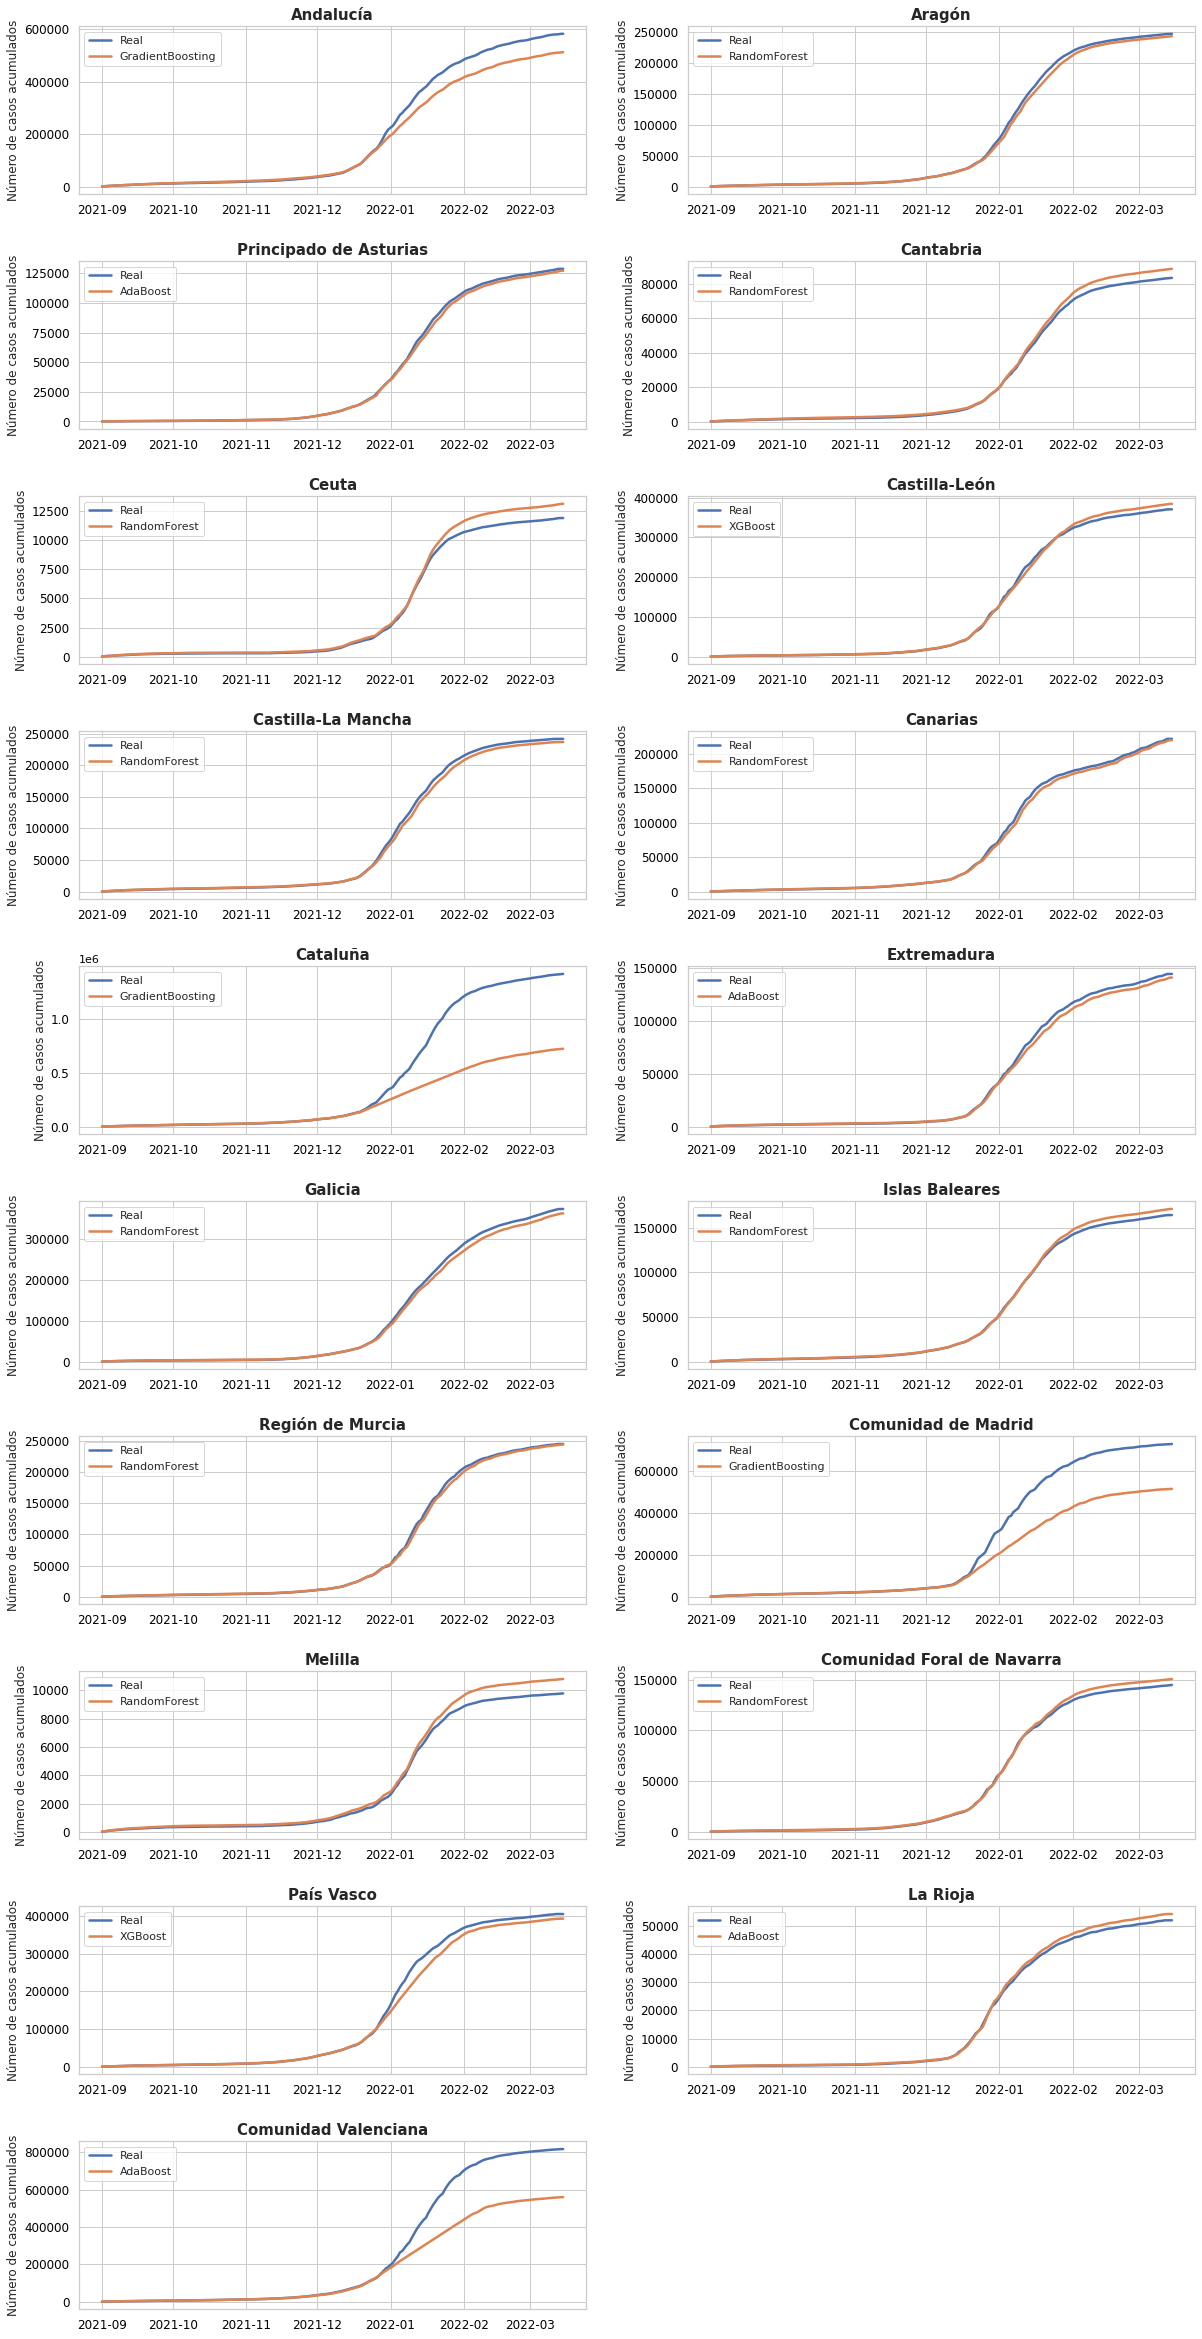

In [60]:
plot_best_model (models_predict_I['RF'], predict_xbg_random_search, 
                 predict_gbr_random_search, predict_abr_random_search,
                 best_models_ccaa_hiper, df1)
plt.savefig("pred.jpg")
files.download("pred.jpg")